In [1]:
import pickle
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import FastICA
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import nibabel as nib
import ants
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
import cv2
import bigbadbrain as bbb
import scipy
from scipy.interpolate import interp1d
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import cm
import matplotlib.colors as mcolors
import matplotlib
import tqdm
import brainsss

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


# Load data

In [2]:
cluster_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/"

In [3]:
hemidiff = pickle.load(open(os.path.join(cluster_dir,"20230202_hemi_turn_diff"),'rb'))
print(hemidiff['all_turn_hists'].shape)
print(hemidiff.keys())
diff = np.asarray(hemidiff['corr_to_diff'])-np.asarray(hemidiff['corr_to_indep'])
print(diff.shape)

(251, 26, 26)
dict_keys(['all_turn_hists', 'all_turn_max', 'corr_to_diff', 'corr_to_indep'])
(251,)


In [4]:
superthresh_corrs = np.load(os.path.join(cluster_dir,'20230203_superthresh_corrs.npy'))
superthresh_slopes = np.load(os.path.join(cluster_dir,'20230203_superthresh_slopes.npy'))
print(superthresh_corrs.shape, superthresh_slopes.shape)

### average hemis with beh flip
st_corrs = []
st_slopes = []
for cluster_ in range(251):
    ### Ipsi turn
    st_corrs.append((superthresh_corrs[cluster_,1] + superthresh_corrs[cluster_+250,2])/2)
    st_slopes.append((superthresh_slopes[cluster_,1] + superthresh_slopes[cluster_+250,2])/2)
    ### contra turn
    st_corrs.append((superthresh_corrs[cluster_,2] + superthresh_corrs[cluster_+250,1])/2)
    st_slopes.append((superthresh_slopes[cluster_,2] + superthresh_slopes[cluster_+250,1])/2)
    ### Fwd
    st_corrs.append((superthresh_corrs[cluster_,0] + superthresh_corrs[cluster_+250,0])/2)
    st_slopes.append((superthresh_slopes[cluster_,0] + superthresh_slopes[cluster_+250,0])/2)
    
st_corrs = np.reshape(np.asarray(st_corrs),(251,3))
st_slopes = np.reshape(np.asarray(st_slopes),(251,3))
print(st_corrs.shape,st_slopes.shape)

(501, 3) (501, 3)
(251, 3) (251, 3)


(array([11., 49., 69., 53., 30., 15., 11.,  5.,  5.,  3.]),
 array([-0.05972106, -0.02013455,  0.01945197,  0.05903848,  0.098625  ,
         0.13821151,  0.17779803,  0.21738455,  0.25697106,  0.29655758,
         0.33614409]),
 <a list of 10 Patch objects>)

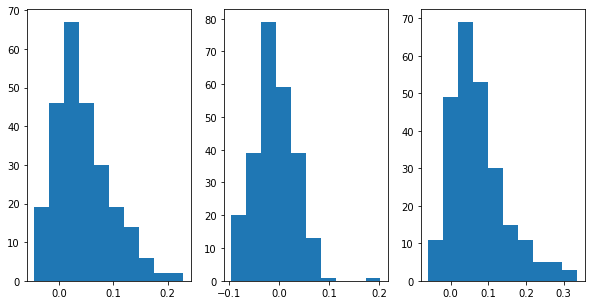

In [7]:
plt.figure(figsize=(10,5))
plt.subplot(131)
plt.hist(st_corrs[:,0])
plt.subplot(132)
plt.hist(st_corrs[:,1])
plt.subplot(133)
plt.hist(st_corrs[:,2])

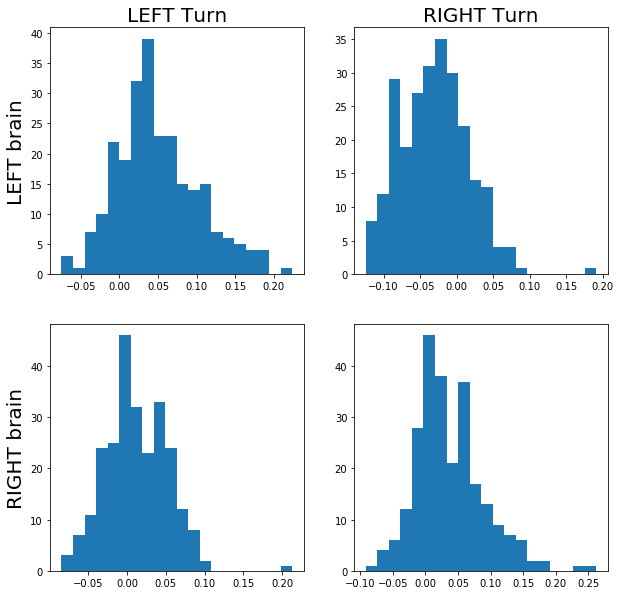

In [78]:
plt.figure(figsize=(10,10))
### LEFT HEMI
plt.subplot(221)
plt.hist(superthresh_corrs[:250,1],bins=20);
plt.title('LEFT Turn',fontsize=20)
plt.ylabel('LEFT brain',fontsize=20)
plt.subplot(222)
plt.title('RIGHT Turn',fontsize=20)
plt.hist(superthresh_corrs[:250,2],bins=20);

### RIGHT HEMI
plt.subplot(223)
plt.hist(superthresh_corrs[250:,1],bins=20);
plt.ylabel('RIGHT brain',fontsize=20)
plt.subplot(224)
plt.hist(superthresh_corrs[250:,2],bins=20);

In [5]:
filters = np.load(os.path.join(cluster_dir,'20230202_SC_temporal_filters.npy'))
print(filters.shape)
### get peaks
peaks = np.argmax(filters,axis=-1)
print(peaks.shape)

(501, 4, 500)
(501, 4)


In [6]:
def NormalizeData(data):
    return (data - np.min(data[:250])) / (np.max(data) - np.min(data[:250]))

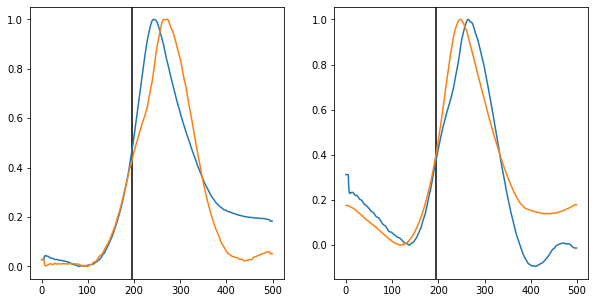

In [30]:
cluster = 77

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.axvline(195,color='k')
plt.plot(NormalizeData(filters[cluster,1,::-1]))
plt.plot(NormalizeData(filters[cluster+250,1,::-1]))

plt.subplot(122)
plt.axvline(195,color='k')
plt.plot(NormalizeData(filters[cluster,2,::-1]))
plt.plot(NormalizeData(filters[cluster+250,2,::-1]))

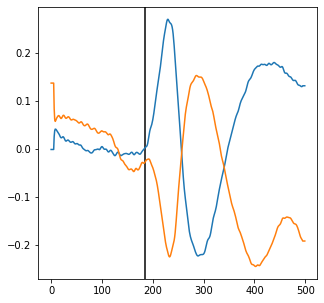

In [41]:
cluster = 77

plt.figure(figsize=(5,5))

plt.axvline(185,color='k')
plt.plot(NormalizeData(filters[cluster,1,::-1])-NormalizeData(filters[cluster+250,1,::-1]))
plt.plot(NormalizeData(filters[cluster,2,::-1])-NormalizeData(filters[cluster+250,2,::-1]))

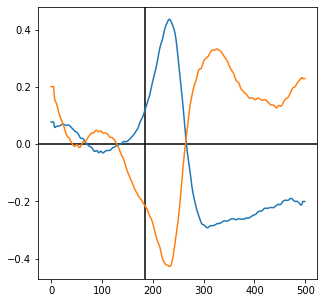

In [43]:
cluster = 158

plt.figure(figsize=(5,5))

plt.axhline(0,color='k')
plt.axvline(185,color='k')
plt.plot(NormalizeData(filters[cluster,1,::-1])-NormalizeData(filters[cluster+250,1,::-1]))
plt.plot(NormalizeData(filters[cluster,2,::-1])-NormalizeData(filters[cluster+250,2,::-1]))

In [21]:
filters[cluster,1,::-1].shape

(500,)

Text(0.5, 0, 'Corr to Contra Turn')

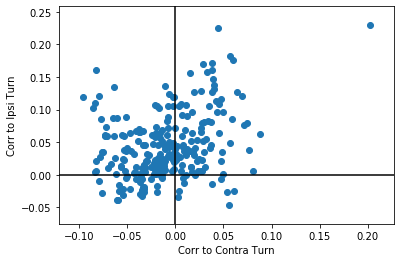

In [12]:
plt.axhline(0,color='k')
plt.axvline(0,color='k')
plt.scatter(st_corrs[:,1],st_corrs[:,0])
plt.ylabel('Corr to Ipsi Turn')
plt.xlabel('Corr to Contra Turn')

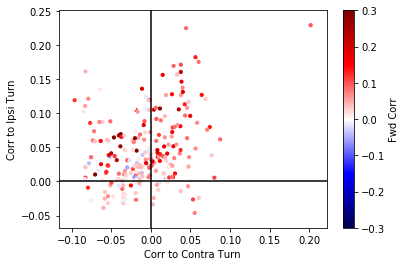

In [12]:
plt.axhline(0,color='k')
plt.axvline(0,color='k')
#plt.scatter(st_corrs[:,1],st_corrs[:,0],c=diff,vmin=-.3,vmax=.,cmap='seismic')
plt.scatter(st_corrs[:,1],st_corrs[:,0],c=st_corrs[:,2],vmin=-.3,vmax=.3,cmap='seismic',s=10)
plt.ylabel('Corr to Ipsi Turn')
plt.xlabel('Corr to Contra Turn')
plt.colorbar(label='Fwd Corr')

In [14]:
### lets visualize these high ipsi low contra on brain
file = os.path.join(cluster_dir, 'superclusters_more.npy')
superclusters = np.load(file)
#with 249 there will be clusters 1-250 inclusive (len=250). cluster 140 is background
superclusters_250 = superclusters[:,:,:,249]
# right brain gets +250 to cluster ID so now 500 clusters
superclusters_250[157:,:,:] += 250

In [45]:
### color brain by peak time
brain = np.zeros((314, 146, 91))
for cluster in tqdm.tqdm(range(250)):
    if st_corrs[cluster,1] > .15: #contra thresh
        if st_corrs[cluster,0] > -0.01: #ipsi thresh
        #print(cluster)
            ind = np.where(superclusters_250==cluster)
            brain[ind[0],ind[1],ind[2]] = 1#st_corrs[cluster,0]*-1

100%|██████████| 250/250 [00:00<00:00, 1215.64it/s]


In [46]:
input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
data_to_plot = brain
vmax = 0.05
explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                    roi_masks,
                                                    roi_contours,
                                                    data_to_plot,
                                                    input_canvas,
                                                    vmax=vmax,
                                                    cmap='hot',
                                                   diverging=False)#'hot'

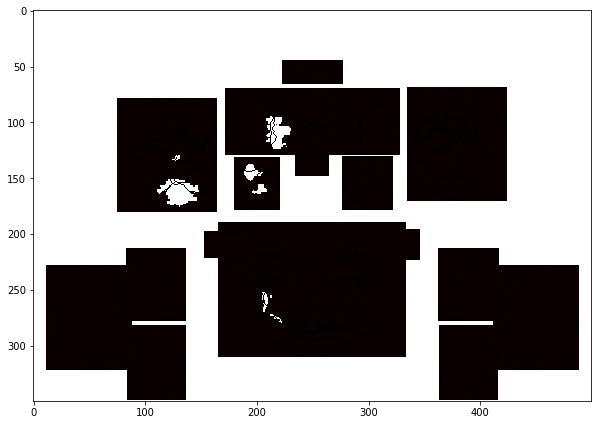

In [47]:
plt.figure(figsize=(10,10))
plt.imshow(explosion_map[150:,:])

In [18]:
atlas_clean = brainsss.load_roi_atlas()
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas_clean)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas_clean)

# what about slope?

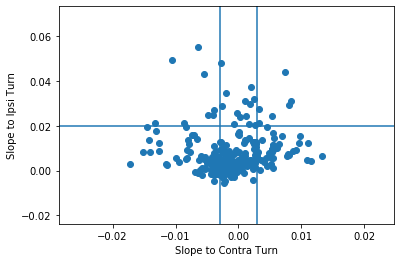

In [14]:
plt.scatter(st_slopes[:,1],st_slopes[:,2])
plt.ylabel('Slope to Ipsi Turn')
plt.xlabel('Slope to Contra Turn')
plt.axhline(.02)
plt.axvline(.003)
plt.axvline(-.003)

  9%|▉         | 22/250 [00:00<00:01, 139.10it/s]

12
21
27


100%|██████████| 250/250 [00:00<00:00, 666.40it/s]

198
224


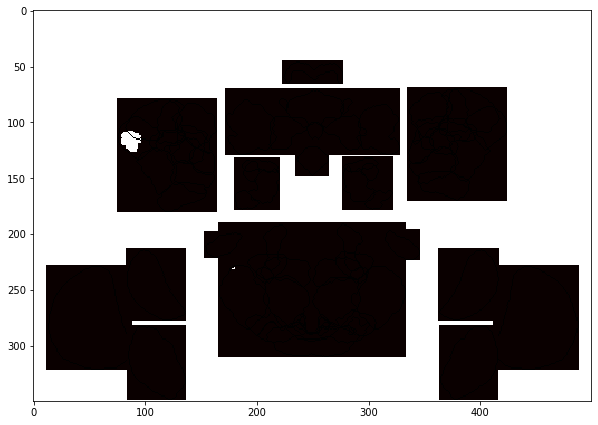

In [95]:
### color brain by peak time
brain = np.zeros((314, 146, 91))
for cluster in tqdm.tqdm(range(250)):
    #if st_slopes[cluster,2] > 0.03:
    if st_slopes[cluster,1] < -0.014:
        #if st_slopes[cluster,1] > -0.003:
    #if st_corrs[cluster,2] > .25:
        print(cluster)
        ind = np.where(superclusters_250==cluster)
        brain[ind[0],ind[1],ind[2]] = 1#st_slopes[cluster,1]*-1

input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
data_to_plot = brain
vmax = 1
explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                    roi_masks,
                                                    roi_contours,
                                                    data_to_plot,
                                                    input_canvas,
                                                    vmax=vmax,
                                                    cmap='hot',
                                                   diverging=False)#'hot'

plt.figure(figsize=(10,10))
plt.imshow(explosion_map[150:,:])

# what about comparing to hemidiff preference?

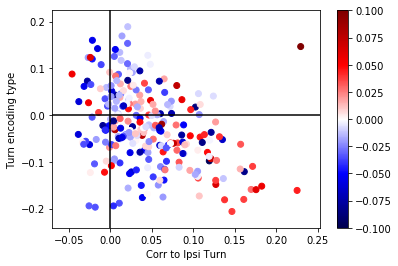

In [54]:
plt.axhline(0,color='k')
plt.axvline(0,color='k')
plt.scatter(st_corrs[:,0],diff,c=st_corrs[:,1],vmin=-.1,vmax=.1,cmap='seismic')
plt.xlabel('Corr to Ipsi Turn')
plt.ylabel('Turn encoding type')
plt.colorbar()

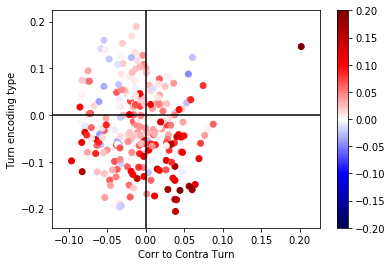

In [57]:
plt.axhline(0,color='k')
plt.axvline(0,color='k')
plt.scatter(st_corrs[:,1],diff,c=st_corrs[:,0],vmin=-.2,vmax=.2,cmap='seismic')
plt.xlabel('Corr to Contra Turn')
plt.ylabel('Turn encoding type')
plt.colorbar()

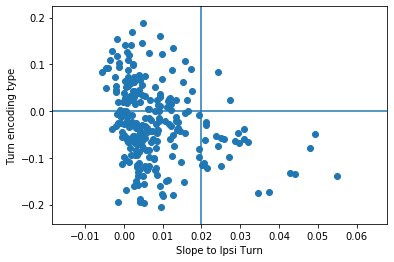

In [80]:
plt.scatter(st_slopes[:,2],diff)
plt.xlabel('Slope to Ipsi Turn')
plt.ylabel('Turn encoding type')
plt.axhline(0)
plt.axvline(.02)

100%|██████████| 250/250 [00:00<00:00, 1299.04it/s]


150
241


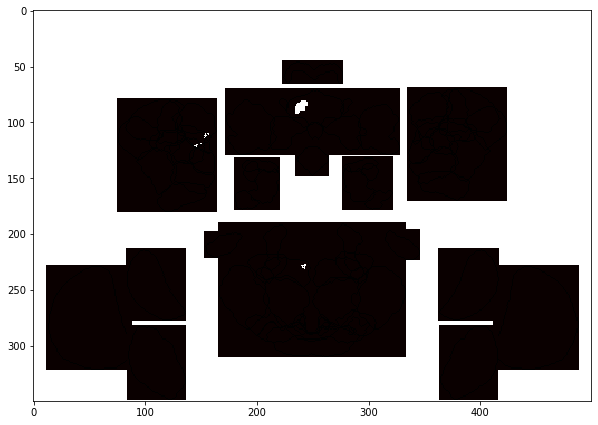

In [81]:
### color brain by peak time
brain = np.zeros((314, 146, 91))
for cluster in tqdm.tqdm(range(250)):
    if diff[cluster] > 0:
        if st_slopes[cluster,2] > 0.02:
        #if st_corrs[cluster,2] > .25:
            print(cluster)
            ind = np.where(superclusters_250==cluster)
            brain[ind[0],ind[1],ind[2]] = 1#st_slopes[cluster,1]*-1

input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
data_to_plot = brain
vmax = 1
explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                    roi_masks,
                                                    roi_contours,
                                                    data_to_plot,
                                                    input_canvas,
                                                    vmax=vmax,
                                                    cmap='hot',
                                                   diverging=False)#'hot'

plt.figure(figsize=(10,10))
plt.imshow(explosion_map[150:,:])

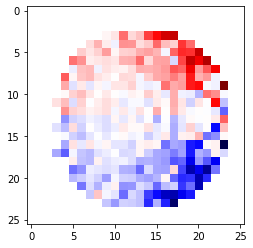

In [15]:
plt.imshow(hemidiff['all_turn_hists'][17,:,:],cmap='seismic',vmin=-1,vmax=1)

# visualize temporal vs turning

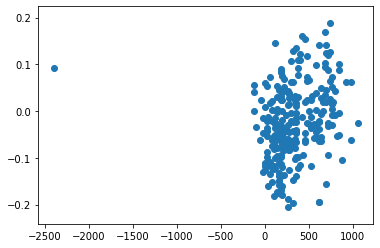

In [7]:
xs = np.arange(-5000,5000,20)*-1
plt.scatter(xs[peaks[:251,1]], diff)

 64%|██████▎   | 159/250 [00:00<00:00, 1457.55it/s]

42
77
104
158
172
175
185
192


100%|██████████| 250/250 [00:00<00:00, 910.51it/s] 


195
235


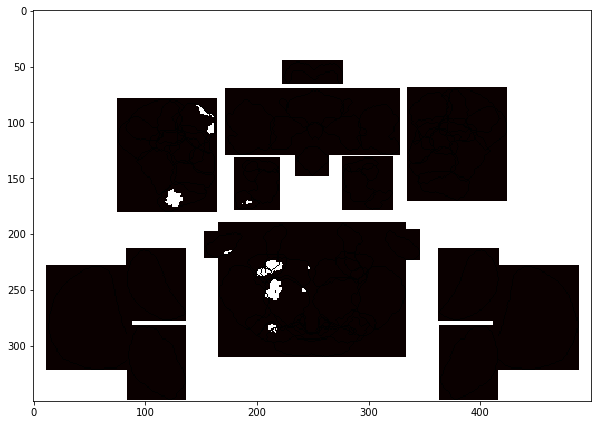

In [10]:
### color brain by peak time
brain = np.zeros((314, 146, 91))
for cluster in tqdm.tqdm(range(250)):
    #if diff[cluster] > 0:
    if xs[peaks[cluster,1]] < 0:
        #if diff[cluster] < 0:
    #if st_corrs[cluster,2] > .25:
        print(cluster)
        ind = np.where(superclusters_250==cluster)
        brain[ind[0],ind[1],ind[2]] = 1#st_slopes[cluster,1]*-1

input_canvas = np.ones((500,500,3)) #+.5 #.5 for diverging
data_to_plot = brain
vmax = 1
explosion_map = brainsss.place_roi_groups_on_canvas(explosion_rois,
                                                    roi_masks,
                                                    roi_contours,
                                                    data_to_plot,
                                                    input_canvas,
                                                    vmax=vmax,
                                                    cmap='hot',
                                                    diverging=False)#'hot'

plt.figure(figsize=(10,10))
plt.imshow(explosion_map[150:,:])

# Mark specific ROIs across all these cool graphs

In [16]:
file = os.path.join(cluster_dir, '20221122_clusters_exploded.npy')
supercluster_visualize = np.load(file)
supercluster_visualize.shape

(501, 350, 500)

In [18]:
st_slopes[77,:]

array([ 0.01928954, -0.00103169, -0.00214776])

(-0.02, 0.02)

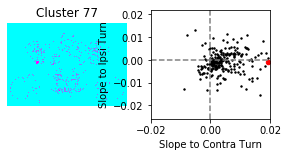

In [19]:
plt.figure(figsize=(15,2))

cluster = 77

plt.subplot(161)
plt.imshow(supercluster_visualize[cluster,:,:],cmap='cool')
plt.axis('off')
plt.title(F"Cluster {cluster}")

plt.subplot(162)
plt.scatter(st_slopes[:,0],st_slopes[:,1],s=2,color='k')
plt.scatter(st_slopes[cluster,0],st_slopes[cluster,1],s=20,color='r')
plt.ylabel('Slope to Ipsi Turn')
plt.xlabel('Slope to Contra Turn')
plt.axhline(0,color='grey',linestyle='--')
plt.axvline(0,color='grey',linestyle='--')
plt.xlim(-.02,.02)

# plt.subplot(163)
# plt.scatter(st_slopes[:,2],diff,s=2,color='k')
# plt.scatter(st_slopes[cluster,2],diff[cluster],s=20,color='r')
# plt.axhline(0,color='grey',linestyle='--')
# plt.axvline(0,color='grey',linestyle='--')
# plt.xlabel('Slope to Ipsi Turn')
# plt.ylabel('Turn encoding type')

# plt.subplot(164)
# plt.scatter(st_slopes[:,1],diff,s=2,color='k')
# plt.scatter(st_slopes[cluster,1],diff[cluster],s=20,color='r')
# plt.xlabel('Slope to Contra Turn')
# plt.ylabel('Turn encoding type')
# plt.axhline(0,color='grey',linestyle='--')
# plt.axvline(0,color='grey',linestyle='--')
# plt.xlim(-.02,.02)

# plt.subplot(165)
# xs = np.arange(-5000,5000,20)*-1
# plt.scatter(xs[peaks[:251,1]], diff,s=2,color='k')
# plt.scatter(xs[peaks[:251,1]][cluster], diff[cluster],s=20,color='r')
# plt.axhline(0,color='grey',linestyle='--')
# plt.axvline(0,color='grey',linestyle='--')
# plt.ylabel('Turn encoding type')
# plt.xlabel('Time (ms)')
# plt.xlim(-300,1200)

# plt.subplot(166)
# plt.imshow(hemidiff['all_turn_hists'][cluster,:,:],cmap='seismic',vmin=-1,vmax=1)

# plt.subplots_adjust(wspace=.5)

# save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
# timestr = time.strftime("%Y%m%d-%H%M%S")
# fname = os.path.join(save_path, f'{timestr}')
# #plt.savefig(fname,dpi=300,bbox_inches='tight')

# process

In [106]:
## remove cluster 192 which is noisy garbage
peaks = np.delete(peaks,192,axis=0)
print(peaks.shape)
diff = np.delete(diff,192)
print(diff.shape)

(500, 4)
(250,)


In [107]:
xs = np.arange(-5000,5000,20)*-1
xs.shape

(500,)

In [111]:
all_turn_max.shape, y.shape

((251,), (250,))

In [112]:
all_turn_max = np.delete(all_turn_max,192)

(array([  1.,  33., 130.,  48.,  27.,   7.,   3.,   0.,   0.,   1.]),
 array([0.07105197, 0.24272196, 0.41439194, 0.58606193, 0.75773192,
        0.92940191, 1.1010719 , 1.27274189, 1.44441188, 1.61608187,
        1.78775186]),
 <a list of 10 Patch objects>)

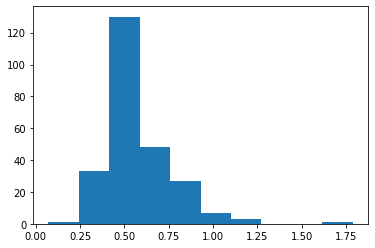

In [114]:
plt.hist(all_turn_max)

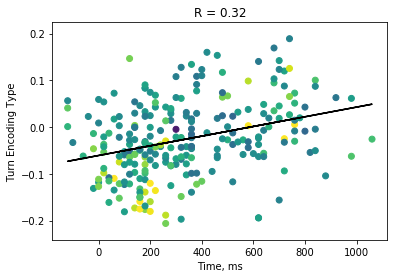

In [117]:
x = xs[peaks[:250,1]]
y = diff

plt.scatter(x, y, c=all_turn_max,vmin=0,vmax=1)
plt.xlabel('Time, ms')
plt.ylabel('Turn Encoding Type')

r,p = scipy.stats.pearsonr(x, y)
plt.title(f'R = {r:.2f}')

#find line of best fit
a, b = np.polyfit(x, y, 1)


#add line of best fit to plot
plt.plot(x, a*x+b,color='k')   

#plt.axvline(250,color='k')

In [118]:
st_slopes[:,2].shape

(251,)

In [124]:
ipsi_slope = np.delete(st_slopes[:,2],192)
contra_slope = np.delete(st_slopes[:,1],192)

(array([ 4.,  7.,  8., 19., 55., 79., 43., 21., 10.,  4.]),
 array([-0.01717933, -0.01413681, -0.01109429, -0.00805177, -0.00500924,
        -0.00196672,  0.0010758 ,  0.00411832,  0.00716084,  0.01020337,
         0.01324589]),
 <a list of 10 Patch objects>)

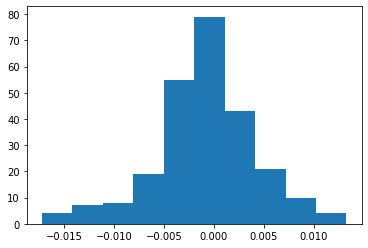

In [125]:
plt.hist(contra_slope)

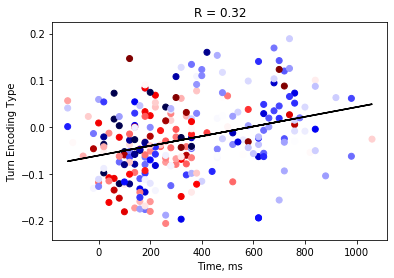

In [126]:
x = xs[peaks[:250,1]]
y = diff

plt.scatter(x, y, c=contra_slope,vmin=-.01,vmax=.01,cmap='seismic')
plt.xlabel('Time, ms')
plt.ylabel('Turn Encoding Type')

r,p = scipy.stats.pearsonr(x, y)
plt.title(f'R = {r:.2f}')

#find line of best fit
a, b = np.polyfit(x, y, 1)


#add line of best fit to plot
plt.plot(x, a*x+b,color='k')   

#plt.axvline(250,color='k')

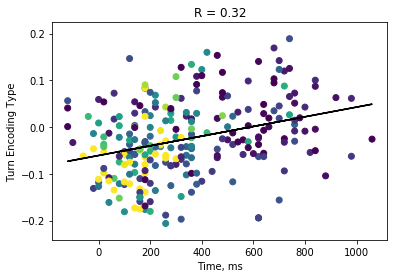

In [123]:
x = xs[peaks[:250,1]]
y = diff

plt.scatter(x, y, c=ipsi_slope,vmin=0,vmax=.02)
plt.xlabel('Time, ms')
plt.ylabel('Turn Encoding Type')

r,p = scipy.stats.pearsonr(x, y)
plt.title(f'R = {r:.2f}')

#find line of best fit
a, b = np.polyfit(x, y, 1)


#add line of best fit to plot
plt.plot(x, a*x+b,color='k')   

#plt.axvline(250,color='k')

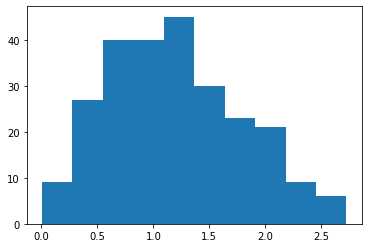

In [70]:
peaks_max = np.max(filters,axis=-1)
plt.hist(peaks_max[:250,1]);

(221, 4)
(222,)


ValueError: x and y must be the same size

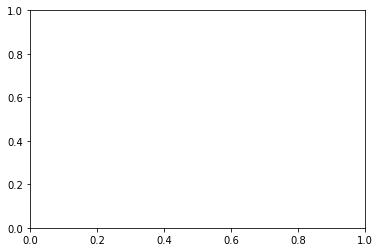

In [104]:
### threshold based on max peak ###

peaks_max = np.max(filters[:250],axis=-1)
to_delete = np.where(peaks_max[:,1]<.5)

peaks_thresh = np.delete(peaks[:250],to_delete,axis=0)
print(peaks_thresh.shape)
diff_thresh = np.delete(diff,to_delete)
print(diff_thresh.shape)
###################################

x = xs[peaks_thresh[:250,1]]
y = diff_thresh

plt.scatter(x, y)
plt.xlabel('Time, ms')
plt.ylabel('Turn Encoding Type')

r,p = scipy.stats.pearsonr(x, y)
plt.title(f'R = {r:.2f}')

#find line of best fit
a, b = np.polyfit(x, y, 1)


#add line of best fit to plot
plt.plot(x, a*x+b,color='k')   

#plt.axvline(250,color='k')

In [106]:
len(hemidiff['all_turn_max'])

251

In [51]:
all_turn_max = np.delete(hemidiff['all_turn_max'],192)
all_turn_max.shape

(250,)

In [58]:
all_turn_max = np.asarray(hemidiff['all_turn_max'])

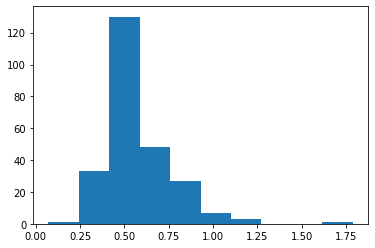

In [110]:
plt.hist(all_turn_max);

In [59]:
all_turn_max.shape

(251,)

(28, 4)
(28,)


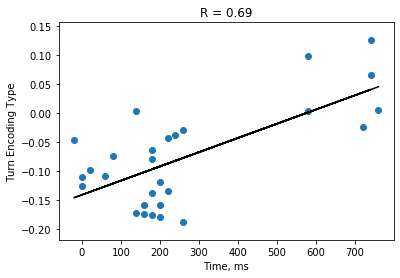

In [103]:
### threshold based on max value in 2d hist (SHOULD UPDATE TO PERCENTILE) ###

#peaks_max = np.max(filters[:250],axis=-1)
to_delete = np.where(np.asarray(all_turn_max)<.8)

peaks_thresh = np.delete(peaks[:250],to_delete,axis=0)
print(peaks_thresh.shape)
diff_thresh = np.delete(diff,to_delete)
print(diff_thresh.shape)
###################################

x = xs[peaks_thresh[:250,1]]
y = diff_thresh

plt.scatter(x, y)
plt.xlabel('Time, ms')
plt.ylabel('Turn Encoding Type')

r,p = scipy.stats.pearsonr(x, y)
plt.title(f'R = {r:.2f}')

#find line of best fit
a, b = np.polyfit(x, y, 1)


#add line of best fit to plot
plt.plot(x, a*x+b,color='k')   

#plt.axvline(250,color='k')

In [117]:
len(hemidiff['corr_to_diff'])

251

In [ ]:
all_turn_max = np.delete(hemidiff['all_turn_max'],192)
all_turn_max.shape

In [ ]:
### threshold based on CORR TO 2D HIST ###

#peaks_max = np.max(filters[:250],axis=-1)
to_delete = np.where(all_turn_max<.8)

peaks_thresh = np.delete(peaks[:250],to_delete,axis=0)
print(peaks_thresh.shape)
diff_thresh = np.delete(diff,to_delete)
print(diff_thresh.shape)
###################################

x = xs[peaks_thresh[:250,1]]
y = diff_thresh

plt.scatter(x, y)
plt.xlabel('Time, ms')
plt.ylabel('Turn Encoding Type')

r,p = scipy.stats.pearsonr(x, y)
plt.title(f'R = {r:.2f}')

#find line of best fit
a, b = np.polyfit(x, y, 1)


#add line of best fit to plot
plt.plot(x, a*x+b,color='k')   

#plt.axvline(250,color='k')